# Assignment 1 | Image Classification, November 12, 2021

- [Artificial Neural Networks and Deep Learning 2021 - Homework 1](https://codalab.lisn.upsaclay.fr/competitions/226)

## Three convolutioneers

- *Aleksandra Krajnovic*
- *Iva Milojkovic*
- *Mariusz Wiśniewski*

### Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import shutil
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tfk.layers
print(tf.__version__)

2.7.0


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 27

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
HISTORIES = []

In [ ]:
def plot_training(histories):
    plt.figure(figsize=(15, 5))
    for idx, history in enumerate(histories):
        plt.plot(history[0]['loss'], label=history[1] + ' training', alpha=.3, color=COLORS[idx], linestyle='--')
        plt.plot(history[0]['val_loss'], label=history[1] + ' validation', alpha=.8, color=COLORS[idx])

    plt.legend(loc='upper right')
    plt.title('Categorical Cross-entropy')
    plt.grid(alpha=.3)

    plt.figure(figsize=(15, 5))
    for idx, history in enumerate(histories):
        plt.plot(history[0]['categorical_accuracy'], label=history[1] + ' training', alpha=.3, color=COLORS[idx],
                 linestyle='--')
        plt.plot(history[0]['val_categorical_accuracy'], label=history[1] + ' validation', alpha=.8, color=COLORS[idx])

    plt.legend(loc='upper right')
    plt.title('Accuracy')
    plt.grid(alpha=.3)

    plt.show()

In [ ]:
# !unzip dataset.zip -d data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Assignment1/

Mounted at /content/drive
[Errno 2] No such file or directory: '/content/drive/Shared with me/Assignment1/'
/content


In [ ]:


dataset_dir = 'data'
training_dir = os.path.join(dataset_dir, 'training')

StopIteration: ignored

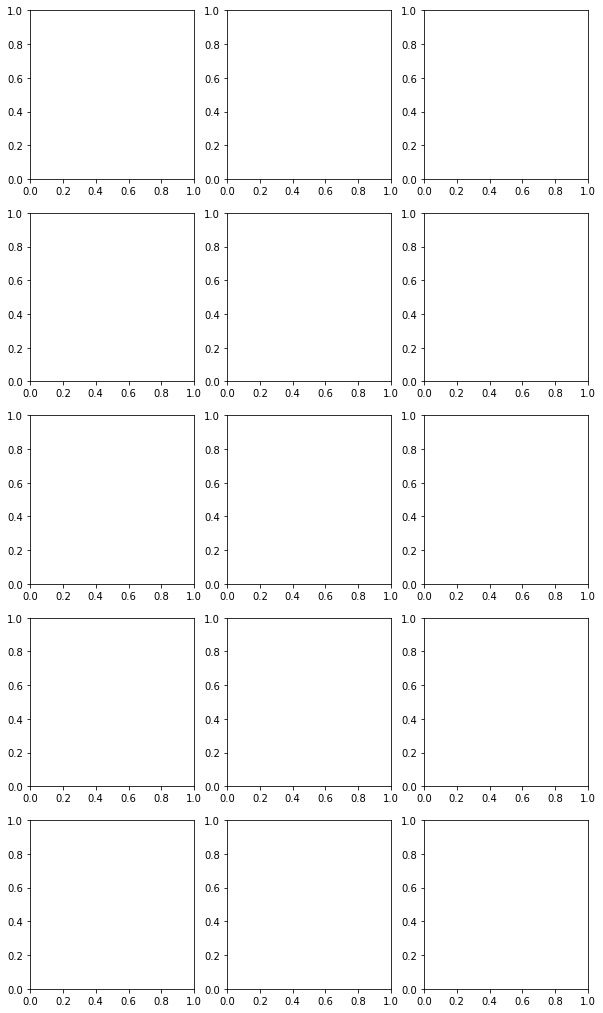

In [ ]:
labels = {0: 'Apple',
          1: 'Blueberry',
          2: 'Cherry',
          3: 'Corn',
          4: 'Grape',
          5: 'Orange',
          6: 'Peach',
          7: 'Pepper',
          8: 'Potato',
          9: 'Raspberry',
          10: 'Soybean',
          11: 'Squash',
          12: 'Strawberry',
          13: 'Tomato'}
# Plot example images from dataset

N_CLASSES = len(labels)

n_rows = 5
n_cols = 3
counts = []

fig, axes = plt.subplots(n_rows, n_cols, figsize=(2 * n_rows, 6 * n_cols))
for i in range(n_rows * n_cols):
    if i < len(labels):
        class_imgs = next(
            os.walk('{}/training/{}/'.format(dataset_dir, labels[i])))[2]
        counts.append(len(class_imgs))
        class_img = class_imgs[0]
        img = Image.open(
            '{}/training/{}/{}'.format(dataset_dir, labels[i], class_img))
        ax = axes[i // n_cols, i % n_cols]
        ax.imshow(np.array(img))
        ax.set_title('{}'.format(labels[i]))
axes[-1, -1].set_visible(False)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))
plt.bar(labels.values(), counts, align='center')
for i in range(len(counts)):
    plt.annotate(str(counts[i]), xy=(labels[i], counts[i]), ha='center', va='bottom')
plt.xlabel('Leaves')
plt.ylabel('Counts')
plt.show()

### Models metadata

In [ ]:
input_shape = (256, 256, 3)
epochs = 200

### Launch Tensorboard (available under http://localhost:6006)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir experiments

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime


def create_folders_and_callbacks(model_name):
    exps_dir = os.path.join('experiments')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)

    callbacks = []

    # Model checkpoint
    # ----------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ckpt_dir, 'cp'),
        save_weights_only=False,
        save_best_only=False)
    callbacks.append(ckpt_callback)

    # Visualize Learning on Tensorboard
    # ---------------------------------
    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
        os.makedirs(tb_dir)

    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                                 profile_batch=0,
                                                 histogram_freq=1)
    callbacks.append(tb_callback)

    # Early Stopping
    # --------------
    es_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True)
    callbacks.append(es_callback)

    return callbacks

## Resnet50

### Basic augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_v2_preprocess_input

rn_no_aug_train_data_gen = ImageDataGenerator(validation_split=0.2,
                                              preprocessing_function=resnet_v2_preprocess_input)

# Create an instance of ImageDataGenerator with Data Augmentation
rn_aug_train_data_gen = ImageDataGenerator(rotation_range=30,
                                           height_shift_range=50,
                                           width_shift_range=50,
                                           zoom_range=0.3,
                                           brightness_range=[0.2, 1.0],
                                           horizontal_flip=True,
                                           vertical_flip=True,
                                           fill_mode='reflect',
                                           validation_split=0.2,
                                           preprocessing_function=resnet_v2_preprocess_input)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
rn_aug_train_gen = rn_aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                             target_size=(
                                                                 256, 256),
                                                             color_mode='rgb',
                                                             classes=None,
                                                             batch_size=8,
                                                             shuffle=True,
                                                             seed=seed,
                                                             subset='training')

rn_valid_gen = rn_no_aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                            target_size=(
                                                                256, 256),
                                                            color_mode='rgb',
                                                            classes=None,
                                                            batch_size=8,
                                                            shuffle=False,
                                                            seed=seed,
                                                            subset='validation')

In [ ]:
resnet_model = tfk.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)
resnet_model.summary()
tfk.utils.plot_model(resnet_model)

#### Transfer learning

In [ ]:
resnet_model.trainable = False

inputs = tfk.Input(shape=input_shape)
out = resnet_model(inputs)
out = tfkl.GlobalAveragePooling2D()(out)
out = tfkl.Flatten(name='Flattening')(out)
out = tfkl.Dropout(0.3, seed=seed)(out)
out = tfkl.Dense(
    256,
    activation='relu',
    kernel_initializer=tfk.initializers.GlorotUniform(seed))(out)
out = tfkl.Dropout(0.3, seed=seed)(out)
outputs = tfkl.Dense(
    N_CLASSES,
    activation='softmax',
    kernel_initializer=tfk.initializers.GlorotUniform(seed))(out)

# # Connect input and output through the Model class
rn_aug_tl_model = tfk.Model(
    inputs=inputs, outputs=outputs, name='rn_aug_tl_model')

# # Compile the model
rn_aug_tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
                        metrics=[
                            tfk.metrics.CategoricalAccuracy(),
                            [tfk.metrics.Precision(class_id=idx, name='Precision_' + labels[idx]) for idx in
                             range(N_CLASSES)],
                            [tfk.metrics.Recall(class_id=idx, name='Recall_' + labels[idx]) for idx in
                             range(N_CLASSES)],
                        ])
rn_aug_tl_model.summary()

In [ ]:
rn_aug_tl_callbacks = create_folders_and_callbacks(model_name='CNN_Aug_RN_TL')

rn_aug_tl_history = rn_aug_tl_model.fit(
    x=rn_aug_train_gen,
    epochs=epochs,
    validation_data=rn_valid_gen,
    callbacks=rn_aug_tl_callbacks,
).history

In [ ]:
HISTORIES.append((rn_aug_tl_history, 'ResNet50V2 TL'))
plot_training(HISTORIES)

In [ ]:
rn_aug_tl_model.save('CNN_Aug_RN_TL')

#### Fine tuning

In [ ]:
# we chose to train the top 2 convolutional blocks, i.e. we will freeze
# the first 86 layers and unfreeze the rest:
for i, layer in enumerate(rn_aug_tl_model.get_layer('resnet50v2').layers):
    print(i, layer.name, layer.trainable)

for layer in rn_aug_tl_model.get_layer('resnet50v2').layers[:86]:
    layer.trainable = False
for layer in rn_aug_tl_model.get_layer('resnet50v2').layers[86:]:
    layer.trainable = True

for i, layer in enumerate(rn_aug_tl_model.get_layer('resnet50v2').layers):
    print(i, layer.name, layer.trainable)

In [ ]:
rn_aug_ft_model = rn_aug_tl_model

rn_aug_ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
                        metrics=[
                            tfk.metrics.CategoricalAccuracy(),
                            [tfk.metrics.Precision(class_id=idx, name='Precision_' + labels[idx]) for idx in
                             range(N_CLASSES)],
                            [tfk.metrics.Recall(class_id=idx, name='Recall_' + labels[idx]) for idx in
                             range(N_CLASSES)],
                        ])
rn_aug_ft_model.summary()

In [ ]:
rn_aug_ft_callbacks = create_folders_and_callbacks(model_name='CNN_Aug_RN_FT')

rn_aug_ft_history = rn_aug_ft_model.fit(
    x=rn_aug_train_gen,
    epochs=epochs,
    validation_data=rn_valid_gen,
    callbacks=rn_aug_ft_callbacks
).history

In [ ]:
HISTORIES.append((rn_aug_ft_history, 'ResNet50V2 FT'))
plot_training(HISTORIES)

In [ ]:
rn_aug_ft_model.save('CNN_Aug_RN_FT')
del rn_aug_tl_model
del rn_aug_ft_model

### Augmentation with class weights adjustments

In [ ]:
# Compute class weights (only once because data distribution remains the same for all data generators, same dataset)
class_weights = class_weight.compute_class_weight(
    'balanced',  # balanced for computing weights based on class count
    np.unique(rn_aug_train_gen.classes),
    rn_aug_train_gen.classes)

class_weights = {idx: class_weights[idx] for idx in range(N_CLASSES)}

print(class_weights)

#### Transfer learning

In [ ]:
resnet_model.trainable = False

inputs = tfk.Input(shape=input_shape)
out = resnet_model(inputs)
out = tfkl.GlobalAveragePooling2D()(out)
out = tfkl.Flatten(name='Flattening')(out)
out = tfkl.Dropout(0.3, seed=seed)(out)
out = tfkl.Dense(
    256,
    activation='relu',
    kernel_initializer=tfk.initializers.GlorotUniform(seed))(out)
out = tfkl.Dropout(0.3, seed=seed)(out)
outputs = tfkl.Dense(
    N_CLASSES,
    activation='softmax',
    kernel_initializer=tfk.initializers.GlorotUniform(seed))(out)

# # Connect input and output through the Model class
rn_aug_tl_model = tfk.Model(
    inputs=inputs, outputs=outputs, name='rn_aug_tl_model')

# # Compile the model
rn_aug_tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
                        metrics=[
                            tfk.metrics.CategoricalAccuracy(),
                            [tfk.metrics.Precision(class_id=idx, name='Precision_' + labels[idx]) for idx in
                             range(N_CLASSES)],
                            [tfk.metrics.Recall(class_id=idx, name='Recall_' + labels[idx]) for idx in
                             range(N_CLASSES)],
                        ])
rn_aug_tl_model.summary()

In [ ]:
rn_aug_tl_callbacks_w = create_folders_and_callbacks(model_name='CNN_Aug_RN_TL_Weights')

rn_aug_tl_history_w = rn_aug_tl_model.fit(
    x=rn_aug_train_gen,
    epochs=epochs,
    validation_data=rn_valid_gen,
    callbacks=rn_aug_tl_callbacks_w,
    class_weight=class_weights
).history

In [ ]:
HISTORIES.append((rn_aug_tl_history_w, 'ResNet50V2 TL Weights'))
plot_training(HISTORIES)

In [ ]:
rn_aug_tl_model.save('CNN_Aug_RN_TL_Weights')

#### Fine tuning

In [ ]:
# we chose to train the top 2 convolutional blocks, i.e. we will freeze
# the first 86 layers and unfreeze the rest:
for i, layer in enumerate(rn_aug_tl_model.get_layer('resnet50v2').layers):
    print(i, layer.name, layer.trainable)

for layer in rn_aug_tl_model.get_layer('resnet50v2').layers[:86]:
    layer.trainable = False
for layer in rn_aug_tl_model.get_layer('resnet50v2').layers[86:]:
    layer.trainable = True

for i, layer in enumerate(rn_aug_tl_model.get_layer('resnet50v2').layers):
    print(i, layer.name, layer.trainable)

In [ ]:
rn_aug_ft_model = rn_aug_tl_model

rn_aug_ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
                        metrics=[
                            tfk.metrics.CategoricalAccuracy(),
                            [tfk.metrics.Precision(class_id=idx, name='Precision_' + labels[idx]) for idx in
                             range(N_CLASSES)],
                            [tfk.metrics.Recall(class_id=idx, name='Recall_' + labels[idx]) for idx in
                             range(N_CLASSES)],
                        ])
rn_aug_ft_model.summary()

In [ ]:
rn_aug_ft_callbacks_w = create_folders_and_callbacks(model_name='CNN_Aug_RN_FT_Weights')

rn_aug_ft_history_w = rn_aug_ft_model.fit(
    x=rn_aug_train_gen,
    epochs=epochs,
    validation_data=rn_valid_gen,
    callbacks=rn_aug_ft_callbacks_w,
    class_weight=class_weights
).history

In [ ]:
HISTORIES.append((rn_aug_ft_history_w, 'ResNet50V2 FT Weights'))
plot_training(HISTORIES)

In [ ]:
rn_aug_ft_model.save('CNN_Aug_RN_FT_Weights')
del rn_aug_tl_model
del rn_aug_ft_model

### Tomato (majority class) reduction

In [ ]:
# 2. Cut off a part of the Tomato data

# The 15% of data remains in the folder, the rest gets moved elsewhere
path = 'data/training/Tomato'
output_folder_name = 'Tomato85'
src_folder = os.path.join(training_dir, 'Tomato')
dest_folder = os.path.join(dataset_dir, output_folder_name)
src_files = os.listdir(src_folder)

os.makedirs(dest_folder, exist_ok=True)

# 15% of files remain, seed is set
for file_to_move in random.sample(src_files, int(len(src_files) * .85)):
    shutil.move(os.path.join(src_folder, file_to_move), dest_folder)

In [ ]:
n_rows = 5
n_cols = 3
counts = []

fig, axes = plt.subplots(n_rows, n_cols, figsize=(2 * n_rows, 6 * n_cols))
for i in range(n_rows * n_cols):
    if i < len(labels):
        class_imgs = next(
            os.walk('{}/training/{}/'.format(dataset_dir, labels[i])))[2]
        counts.append(len(class_imgs))
        class_img = class_imgs[0]
        img = Image.open(
            '{}/training/{}/{}'.format(dataset_dir, labels[i], class_img))
        ax = axes[i // n_cols, i % n_cols]
        ax.imshow(np.array(img))
        ax.set_title('{}'.format(labels[i]))
axes[-1, -1].set_visible(False)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))
plt.bar(labels.values(), counts, align='center')
for i in range(len(counts)):
    plt.annotate(str(counts[i]), xy=(
        labels[i], counts[i]), ha='center', va='bottom')
plt.xlabel('Leaves')
plt.ylabel('Counts')
plt.show()

#### Transfer learning

In [ ]:
rn_no_aug_train_data_gen = ImageDataGenerator(validation_split=0.2,
                                              preprocessing_function=resnet_v2_preprocess_input)

# Create an instance of ImageDataGenerator with Data Augmentation
rn_aug_train_data_gen = ImageDataGenerator(rotation_range=30,
                                           height_shift_range=50,
                                           width_shift_range=50,
                                           zoom_range=0.3,
                                           brightness_range=[0.2, 1.0],
                                           horizontal_flip=True,
                                           vertical_flip=True,
                                           fill_mode='reflect',
                                           validation_split=0.2,
                                           preprocessing_function=resnet_v2_preprocess_input)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
rn_aug_train_gen = rn_aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                             target_size=(
                                                                 256, 256),
                                                             color_mode='rgb',
                                                             classes=None,
                                                             batch_size=8,
                                                             shuffle=True,
                                                             seed=seed,
                                                             subset='training')

rn_valid_gen = rn_no_aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                            target_size=(
                                                                256, 256),
                                                            color_mode='rgb',
                                                            classes=None,
                                                            batch_size=8,
                                                            shuffle=False,
                                                            seed=seed,
                                                            subset='validation')

In [ ]:
resnet_model.trainable = False

inputs = tfk.Input(shape=input_shape)
out = resnet_model(inputs)
out = tfkl.GlobalAveragePooling2D()(out)
out = tfkl.Flatten(name='Flattening')(out)
out = tfkl.Dropout(0.3, seed=seed)(out)
out = tfkl.Dense(
    256,
    activation='relu',
    kernel_initializer=tfk.initializers.GlorotUniform(seed))(out)
out = tfkl.Dropout(0.3, seed=seed)(out)
outputs = tfkl.Dense(
    N_CLASSES,
    activation='softmax',
    kernel_initializer=tfk.initializers.GlorotUniform(seed))(out)

# # Connect input and output through the Model class
rn_aug_tl_model = tfk.Model(
    inputs=inputs, outputs=outputs, name='rn_aug_tl_model')

# # Compile the model
rn_aug_tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
                        metrics=[
                            tfk.metrics.CategoricalAccuracy(),
                            [tfk.metrics.Precision(class_id=idx, name='Precision_' + labels[idx]) for idx in
                             range(N_CLASSES)],
                            [tfk.metrics.Recall(class_id=idx, name='Recall_' + labels[idx]) for idx in
                             range(N_CLASSES)],
                        ])
rn_aug_tl_model.summary()

In [ ]:
rn_aug_tl_callbacks_r = create_folders_and_callbacks(model_name='CNN_Aug_RN_TL_Reduced')

rn_aug_tl_history_r = rn_aug_tl_model.fit(
    x=rn_aug_train_gen,
    epochs=epochs,
    validation_data=rn_valid_gen,
    callbacks=rn_aug_tl_callbacks_r
).history

In [ ]:
HISTORIES.append((rn_aug_tl_history_r, 'ResNet50V2 TL Reduced'))
plot_training(HISTORIES)

In [ ]:
rn_aug_tl_model.save('CNN_Aug_RN_TL_Reduced')

#### Fine tuning

In [ ]:
# we chose to train the top 2 convolutional blocks, i.e. we will freeze
# the first 86 layers and unfreeze the rest:
for i, layer in enumerate(rn_aug_tl_model.get_layer('resnet50v2').layers):
    print(i, layer.name, layer.trainable)

for layer in rn_aug_tl_model.get_layer('resnet50v2').layers[:86]:
    layer.trainable = False
for layer in rn_aug_tl_model.get_layer('resnet50v2').layers[86:]:
    layer.trainable = True

for i, layer in enumerate(rn_aug_tl_model.get_layer('resnet50v2').layers):
    print(i, layer.name, layer.trainable)

In [ ]:
rn_aug_ft_model = rn_aug_tl_model

rn_aug_ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
                        metrics=[
                            tfk.metrics.CategoricalAccuracy(),
                            [tfk.metrics.Precision(class_id=idx, name='Precision_' + labels[idx]) for idx in
                             range(N_CLASSES)],
                            [tfk.metrics.Recall(class_id=idx, name='Recall_' + labels[idx]) for idx in
                             range(N_CLASSES)],
                        ])
rn_aug_ft_model.summary()

In [ ]:
rn_aug_ft_callbacks_r = create_folders_and_callbacks(model_name='CNN_Aug_RN_FT_Reduced')

rn_aug_ft_history_r = rn_aug_ft_model.fit(
    x=rn_aug_train_gen,
    epochs=epochs,
    validation_data=rn_valid_gen,
    callbacks=rn_aug_ft_callbacks_r
).history

In [ ]:
HISTORIES.append((rn_aug_ft_history_r, 'ResNet50V2 FT Reduced'))
plot_training(HISTORIES)

In [ ]:
rn_aug_ft_model.save('CNN_Aug_RN_FT_Reduced')
del rn_aug_tl_model
del rn_aug_ft_model

#### Merge back the Tomato85/ folder

In [ ]:
# The 15% of data remains in the folder, the rest gets moved elsewhere
path = 'data/training/Tomato'
output_folder_name = 'Tomato85'
dest_folder = os.path.join(training_dir, 'Tomato')
src_folder = os.path.join(dataset_dir, output_folder_name)
src_files = os.listdir(src_folder)

os.makedirs(dest_folder, exist_ok=True)

# 15% of files remain, seed is set
for file_to_move in random.sample(src_files, int(len(src_files))):
    shutil.move(os.path.join(src_folder, file_to_move), dest_folder)

os.rmdir(src_folder)